In [1]:
import numpy as np

from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

from data import get_data, meta

In [2]:
sns.set()

In [3]:
fig_folder = 'plots'

data = get_data()

data['ucs'] = data['ucs'].apply(np.log)
data['e_din_seco'] = data['e_din_seco'].apply(np.log)
data['e_din_sat'] = data['e_din_sat'].apply(np.log)
data['e_est_sat'] = data['e_est_sat'].apply(np.log)

<ipython-input-4-413f1f9b6c61>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  model_data = model_data[data["descartados_e"] == 0][[x, y]]


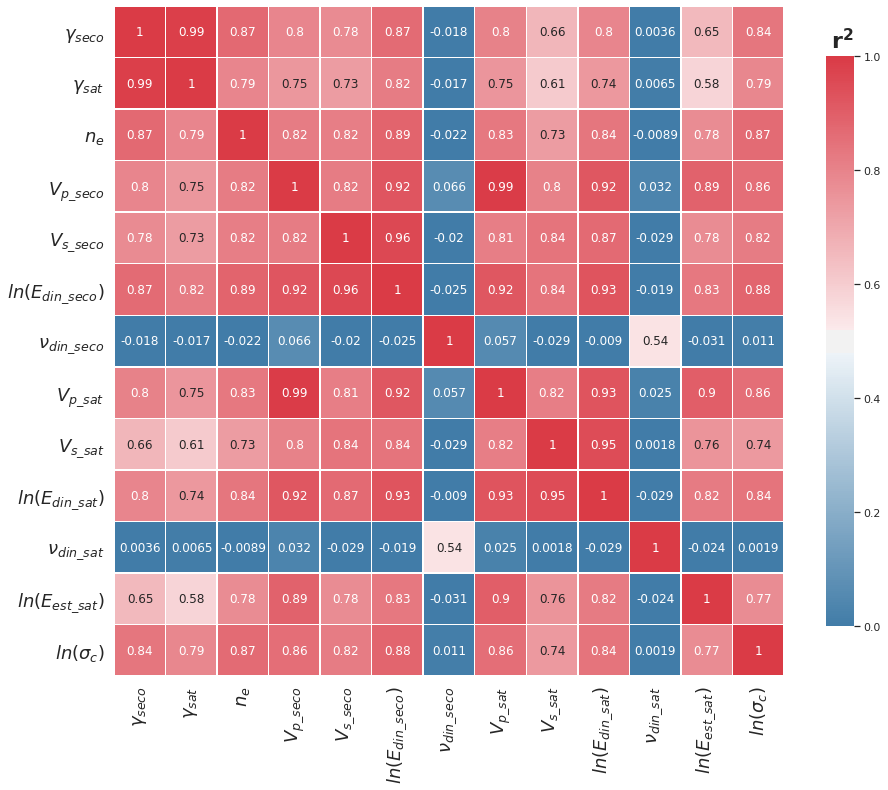

In [4]:
corr_df = data.drop(columns=[
    'litologia', 
    'teor_umidade',
    'descartados_ucs', 
    'descartados_e'
]).corr()

formula = '%s ~ %s'

for x in corr_df:
    for y, row in corr_df.iterrows():
        if x == y:
            continue
            
        model_data = data[[x, y]]

        if ([x, y].count('ucs') > 0):
            model_data = model_data[data["descartados_ucs"] == 0][[x, y]]

        if ([x, y].count('e_est_sat') > 0):
            model_data = model_data[data["descartados_e"] == 0][[x, y]]

        if ([x, y].count('vs_seco') > 0) | ([x, y].count('vs_sat') > 0):
            model_data = model_data.drop(['GB02-02', 'GB02-05'], errors='ignore')[[x, y]]
            
        if ([x, y].count('e_din_seco') > 0) | ([x, y].count('e_din_sat') > 0):
            model_data = model_data.drop(['GB02-02', 'GB02-05'], errors='ignore')[[x, y]]

        if ([x, y].count('poisson_din_seco') > 0) | ([x, y].count('poisson_din_sat') > 0):
            model_data = model_data.drop(['GB02-02', 'GB02-05'], errors='ignore')[[x, y]]
            
        reg =  ols(formula=formula % (y, x), data=model_data).fit()
        corr_df.at[x, y] = reg.rsquared_adj

cols = { col: '$%s$' % meta[col]['symbol'] for col in corr_df.columns }

for col in ['ucs', 'e_din_seco', 'e_din_sat', 'e_est_sat']:
    cols[col] = '$ln(%s)$' % meta[col]['symbol']

corr_df = corr_df.rename(columns=cols, index=cols)

figure, ax = plt.subplots(figsize=(15, 15))

cmap = sns.diverging_palette(240, 10, as_cmap=True)
ax = sns.heatmap(corr_df, cmap=cmap, vmin=0, vmax=1, center=0.5, square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .7}, ax=ax)
ax.set_ylim(13, 0)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='x', which='major', rotation=90)

ax.text(1.07, 0.95, r'$\bf{r^2}$', fontsize=22, transform=ax.transAxes, verticalalignment='center')

plt.savefig('%s/matriz_correlacao.png' % (fig_folder), bbox_inches='tight', dpi=120)
plt.show()